In [1]:
!apt-get update && apt-get install swig cmake
!pip install box2d-py
!pip install "stable-baselines3[extra]>=2.0.0a4"
!pip install sb3-contrib

Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Get:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:10 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3,342 kB]
Get:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease [24.3 kB]
Get:12 http://archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [2,664 kB]
Get:13 http://archive.ubuntu.com/ubuntu focal-updates/universe am

In [2]:
import gymnasium as gym
import numpy as np
from stable_baselines3 import DQN
from sb3_contrib.qrdqn import QRDQN
from stable_baselines3.common.evaluation import evaluate_policy
import os
from stable_baselines3.common.monitor import Monitor
import matplotlib.pyplot as plt
from stable_baselines3.common.results_plotter import plot_results, ts2xy
from stable_baselines3.common.monitor import load_results
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
from IPython import display as ipythondisplay
import base64
from pathlib import Path
import warnings
from typing import Any, ClassVar, Dict, List, Optional, Tuple, Type, TypeVar, Union
import torch as th
from gymnasium import spaces
from stable_baselines3.common.buffers import ReplayBuffer
from stable_baselines3.common.off_policy_algorithm import OffPolicyAlgorithm
from stable_baselines3.common.policies import BasePolicy
from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback, Schedule
from stable_baselines3.common.utils import get_linear_fn, get_parameters_by_name, polyak_update

from sb3_contrib.common.utils import quantile_huber_loss
from sb3_contrib.qrdqn.policies import CnnPolicy, MlpPolicy, MultiInputPolicy, QRDQNPolicy, QuantileNetwork

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/usr/local/lib/python3.10/dist-packages/jaxlib/xla_client.py:225: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  float8_e4m3b11fnuz = ml_dtypes.float8_e4m3b11


In [3]:
class new_QRDQN(QRDQN):
    policy_aliases: ClassVar[Dict[str, Type[BasePolicy]]] = {
        "MlpPolicy": MlpPolicy,
        "CnnPolicy": CnnPolicy,
        "MultiInputPolicy": MultiInputPolicy,
    }
    # Linear schedule will be defined in `_setup_model()`
    exploration_schedule: Schedule
    quantile_net: QuantileNetwork
    quantile_net_target: QuantileNetwork
    policy : QRDQNPolicy

    def __init__(
        self,
        policy: Union[str, Type[QRDQNPolicy]],
        env: Union[GymEnv, str],
        learning_rate: Union[float, Schedule] = 5e-5,
        buffer_size: int = 1000000,  # 1e6
        learning_starts: int = 50000,
        batch_size: int = 32,
        tau: float = 1.0,
        gamma: float = 0.99,
        train_freq: int = 4,
        gradient_steps: int = 1,
        replay_buffer_class: Optional[Type[ReplayBuffer]] = None,
        replay_buffer_kwargs: Optional[Dict[str, Any]] = None,
        optimize_memory_usage: bool = False,
        target_update_interval: int = 10000,
        exploration_fraction: float = 0.005,
        exploration_initial_eps: float = 1.0,
        exploration_final_eps: float = 0.01,
        max_grad_norm: Optional[float] = None,
        stats_window_size: int = 100,
        tensorboard_log: Optional[str] = None,
        policy_kwargs: Optional[Dict[str, Any]] = None,
        verbose: int = 0,
        seed: Optional[int] = None,
        device: Union[th.device, str] = "auto",
        _init_setup_model: bool = True,
    ):
        super().__init__(
            policy,
            env,
            learning_rate,
            buffer_size,
            learning_starts,
            batch_size,
            tau,
            gamma,
            train_freq,
            gradient_steps,
            #action_noise=None,  # No action noise
            replay_buffer_class=replay_buffer_class,
            replay_buffer_kwargs=replay_buffer_kwargs,
            policy_kwargs=policy_kwargs,
            stats_window_size=stats_window_size,
            tensorboard_log=tensorboard_log,
            verbose=verbose,
            device=device,
            seed=seed,
            #sde_support=False,
            optimize_memory_usage=optimize_memory_usage,
            #supported_action_spaces=(spaces.Discrete,),
            #support_multi_env=True,
        )

        self.exploration_initial_eps = exploration_initial_eps
        self.exploration_final_eps = exploration_final_eps
        self.exploration_fraction = exploration_fraction
        self.target_update_interval = target_update_interval
        # For updating the target network with multiple envs:
        self._n_calls = 0
        self.max_grad_norm = max_grad_norm
        # "epsilon" for the epsilon-greedy exploration
        self.exploration_rate = 0.0

        if "optimizer_class" not in self.policy_kwargs:
            self.policy_kwargs["optimizer_class"] = th.optim.Adam
            # Proposed in the QR-DQN paper where `batch_size = 32`
            self.policy_kwargs["optimizer_kwargs"] = dict(eps=0.01 / batch_size)

        if _init_setup_model:
            self._setup_model()


    def train(self, gradient_steps: int, batch_size: int = 100) -> None:
        # Switch to train mode (this affects batch norm / dropout)
        self.policy.set_training_mode(True)
        # Update learning rate according to schedule
        self._update_learning_rate(self.policy.optimizer)

        losses = []
        for _ in range(gradient_steps):
            # Sample replay buffer
            replay_data = self.replay_buffer.sample(batch_size, env=self._vec_normalize_env)  # type: ignore[union-attr]

            with th.no_grad():
                # Compute the quantiles of next observation
                next_quantiles = self.quantile_net_target(replay_data.next_observations)

                next_action = self.quantile_net(replay_data.next_observations)

                # Compute the greedy actions which maximize the next Q values
                next_greedy_actions = next_action.mean(dim=1, keepdim=True).argmax(dim=2, keepdim=True)

                # Make "n_quantiles" copies of actions, and reshape to (batch_size, n_quantiles, 1)
                next_greedy_actions = next_greedy_actions.expand(batch_size, self.n_quantiles, 1)
                # Follow greedy policy: use the one with the highest Q values
                next_quantiles = next_quantiles.gather(dim=2, index=next_greedy_actions).squeeze(dim=2)
                # 1-step TD target
                target_quantiles = replay_data.rewards + (1 - replay_data.dones) * self.gamma * next_quantiles

            # Get current quantile estimates
            current_quantiles = self.quantile_net(replay_data.observations)

            # Make "n_quantiles" copies of actions, and reshape to (batch_size, n_quantiles, 1).
            actions = replay_data.actions[..., None].long().expand(batch_size, self.n_quantiles, 1)
            # Retrieve the quantiles for the actions from the replay buffer
            current_quantiles = th.gather(current_quantiles, dim=2, index=actions).squeeze(dim=2)

            # Compute Quantile Huber loss, summing over a quantile dimension as in the paper.
            loss = quantile_huber_loss(current_quantiles, target_quantiles, sum_over_quantiles=True)
            losses.append(loss.item())

            # Optimize the policy
            self.policy.optimizer.zero_grad()
            loss.backward()
            # Clip gradient norm
            if self.max_grad_norm is not None:
                th.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
            self.policy.optimizer.step()

        # Increase update counter
        self._n_updates += gradient_steps

        self.logger.record("train/n_updates", self._n_updates, exclude="tensorboard")
        self.logger.record("train/loss", np.mean(losses))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
ENVIROMENT =  "CartPole-v0"
POLICY = "MlpPolicy"

#  "MlpPolicy"  "CnnPolicy"

# enviroment  = 'MsPacman-v0'   "LunarLander-v2"   "ALE/MsPacman-v5"   "CartPole-v0"
list_OF_quantiles = [5 , 10 , 15 , 20 , 25 , 30]
ENVIROMENT = "CartPole-v0"
POLICY = "MlpPolicy"
log_folders = []
for i , quantile in zip(range(1,len(list_OF_quantiles)+1) , list_OF_quantiles):

      # Train the agent
      log_dir = f"temp{i}"
      os.makedirs(log_dir, exist_ok=True)
      log_folders.append(log_dir)

      env = gym.make(ENVIROMENT)
      env = Monitor(env, log_dir)

      policy_kwargs = dict(n_quantiles = quantile)

      model = new_QRDQN(POLICY, env, policy_kwargs=policy_kwargs, verbose=1)
      model.learn(total_timesteps=int(350000), log_interval=4)

      # Save the agent
      model.save(f"QR_dqn_{ENVIROMENT}")
      del model

Using cpu device
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27.8     |
|    ep_rew_mean      | 27.8     |
|    exploration_rate | 0.937    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1732     |
|    time_elapsed     | 0        |
|    total_timesteps  | 111      |
----------------------------------


/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:523: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


Streaming output truncated to the last 5000 lines.
| train/              |          |
|    learning_rate    | 5e-05    |
|    loss             | 2.33     |
|    n_updates        | 10349    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 75.9     |
|    ep_rew_mean      | 75.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 4908     |
|    fps              | 1003     |
|    time_elapsed     | 91       |
|    total_timesteps  | 91688    |
| train/              |          |
|    learning_rate    | 5e-05    |
|    loss             | 1.75     |
|    n_updates        | 10421    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 77       |
|    ep_rew_mean      | 77       |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 4912     |
|   

In [ ]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folders, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """


    fig = plt.figure(title , figsize=(7,7))

    for i in range(len(list_OF_quantiles)):
          log_folder = log_folders[i]
          x , y = ts2xy(load_results(log_folder), 'timesteps')
          y = moving_average(y, window=50)
          # Truncate x
          x = x[len(x) - len(y):]

          plt.plot(x, y , label = f"{list_OF_quantiles[i]} quantiles")
          plt.xlabel('Number of Timesteps')
          plt.ylabel('Rewards')
          plt.title(title + " Smoothed")
    plt.legend()
    plt.show()

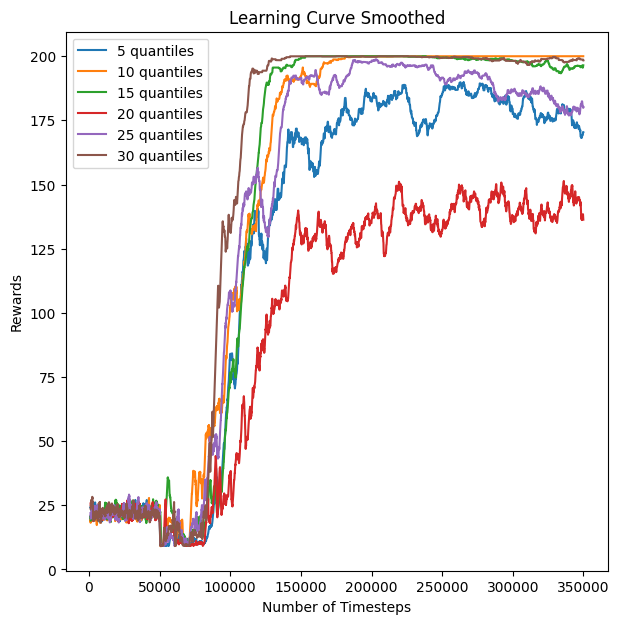

In [ ]:
plot_results(log_folders)

In [ ]:
#  "MlpPolicy"  "CnnPolicy"

# enviroment  = 'MsPacman-v0'   "LunarLander-v2"   "ALE/MsPacman-v5"   "CartPole-v0"

ENVIROMENT = 'CartPole-v0'
POLICY = "MlpPolicy"

# Train the agent
log_dir = "temp1"
os.makedirs(log_dir, exist_ok=True)

env = gym.make(ENVIROMENT)
env = Monitor(env, log_dir)

policy_kwargs = dict(n_quantiles=15)

model = QRDQN(POLICY, env, policy_kwargs=policy_kwargs, verbose=1 , batch_size = 32 )
model.learn(total_timesteps=int(350000), log_interval=4)

# Save the agent
model.save(f"QR_dqn_{ENVIROMENT}")
del model  # delete trained model to demonstrate loading
model = QRDQN.load(f"QR_dqn_{ENVIROMENT}")

Using cpu device
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.5     |
|    ep_rew_mean      | 15.5     |
|    exploration_rate | 0.965    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 5039     |
|    time_elapsed     | 0        |
|    total_timesteps  | 62       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.6     |
|    ep_rew_mean      | 19.6     |
|    exploration_rate | 0.911    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 5004     |
|    time_elapsed     | 0        |
|    total_timesteps  | 157      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.1     |
|    ep_rew_mean      | 19.1     |
|    exploration_rate | 0.87     |
| t

/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:523: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


Streaming output truncated to the last 5000 lines.
| train/              |          |
|    learning_rate    | 5e-05    |
|    loss             | 2.23     |
|    n_updates        | 21022    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 60.6     |
|    ep_rew_mean      | 60.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 7192     |
|    fps              | 801      |
|    time_elapsed     | 167      |
|    total_timesteps  | 134300   |
| train/              |          |
|    learning_rate    | 5e-05    |
|    loss             | 2.56     |
|    n_updates        | 21074    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 60       |
|    ep_rew_mean      | 60       |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 7196     |
|   

In [ ]:
# Evaluate the trained agent
eval_env = gym.make(ENVIROMENT)
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10, deterministic=True)
print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward=183.40 +/- 17.442476888332116


In [ ]:
list_OF_model = [QRDQN , new_QRDQN]

In [13]:
ENVIROMENT =  "CartPole-v0"
POLICY = "MlpPolicy"
list_OF_model = [QRDQN , new_QRDQN]
#  "MlpPolicy"  "CnnPolicy"

# enviroment  = 'MsPacman-v0'   "LunarLander-v2"   "ALE/MsPacman-v5"   "CartPole-v0"
ENVIROMENT = "CartPole-v0"
POLICY = "MlpPolicy"
log_folders = []
for i in range(1,len(list_OF_model)+1):

      # Train the agent
      log_dir = f"temp{i}"
      os.makedirs(log_dir, exist_ok=True)
      log_folders.append(log_dir)

      env = gym.make(ENVIROMENT)
      env = Monitor(env, log_dir)

      policy_kwargs = dict(n_quantiles = 15)
      M = list_OF_model[i-1]
      model = M(POLICY, env, policy_kwargs=policy_kwargs, verbose=1)
      model.learn(total_timesteps=int(350000), log_interval=4)

      # Save the agent
      model.save(f"QR_dqn_{ENVIROMENT}")
      del model

Using cpu device
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24.8     |
|    ep_rew_mean      | 24.8     |
|    exploration_rate | 0.944    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 9507     |
|    time_elapsed     | 0        |
|    total_timesteps  | 99       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 21.8     |
|    ep_rew_mean      | 21.8     |
|    exploration_rate | 0.902    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 7896     |
|    time_elapsed     | 0        |
|    total_timesteps  | 174      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 25.1     |
|    ep_rew_mean      | 25.1     |
|    exploration_rate | 0.83     |
| t

/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:523: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


Streaming output truncated to the last 5000 lines.
| train/              |          |
|    learning_rate    | 5e-05    |
|    loss             | 2.51     |
|    n_updates        | 23010    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90.2     |
|    ep_rew_mean      | 90.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 6792     |
|    fps              | 952      |
|    time_elapsed     | 149      |
|    total_timesteps  | 142401   |
| train/              |          |
|    learning_rate    | 5e-05    |
|    loss             | 2.72     |
|    n_updates        | 23100    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92.5     |
|    ep_rew_mean      | 92.5     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 6796     |
|   

In [11]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folders, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """


    fig = plt.figure(title , figsize=(7,7))

    for i in range(len(list_OF_model)):
          log_folder = log_folders[i]
          x , y = ts2xy(load_results(log_folder), 'timesteps')
          y = moving_average(y, window=50)
          # Truncate x
          x = x[len(x) - len(y):]
          list_Of_model = ['QRDQN' , 'modified-QRDQN']
          plt.plot(x, y , label = f"{list_Of_model[i]} quantiles")
          plt.xlabel('Number of Timesteps')
          plt.ylabel('Rewards')
          plt.title(title + " Smoothed")
    plt.legend()
    plt.show()

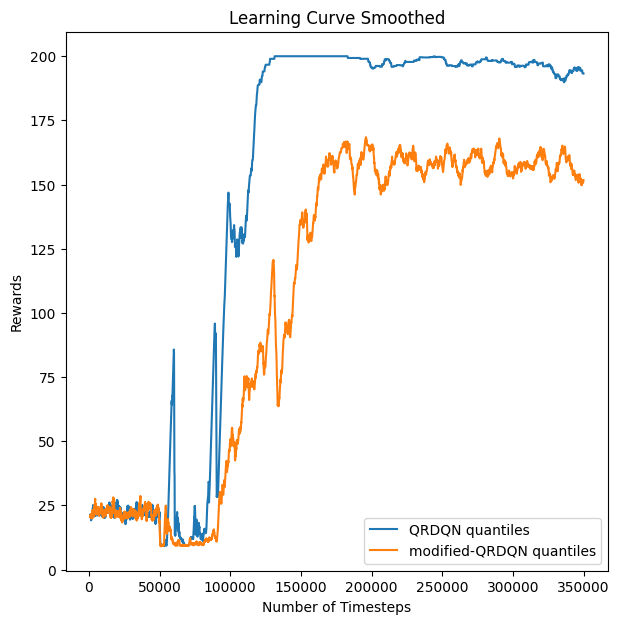

In [14]:
plot_results(log_folders)